In [2]:
from dotenv import load_dotenv
load_dotenv() # OPENAI_API_KEY, PINECONE_API_KEY

True

In [3]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

llm = ChatOpenAI(model="gpt-4.1", temperature=0)
small_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = PineconeVectorStore(
    index_name="inhouse-python-index",
    embedding=embeddings,
)
retriever = vector_store.as_retriever()

/Users/al02022579/Documents/GitHub/n8n-use-cases/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langgraph.graph import StateGraph, MessagesState
    
graph_builder = StateGraph(MessagesState)

In [6]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool
from langchain_core.documents import Document
from pydantic import BaseModel

class CheckFaqResponse(BaseModel):
    is_in_faq: bool
    context: list[Document]

@tool
def check_faq(question: str) -> CheckFaqResponse:
    """Check if the question is in the FAQ.
    If the question is in the FAQ, return the context of the question.
    Otherwise, return an empty list.
    """
    context = retriever.invoke(question, filter={"source": "employee_benefits_and_welfare_faq"})
    check_faq_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that checks if the question is in the FAQ. 
If the question is in the FAQ, return 'Yes'. Otherwise, return 'No'."""),
        ("user", "Question: {question}\nContext: {context}"),
    ])
    check_faq_chain = check_faq_prompt | llm | StrOutputParser()
    is_in_faq = check_faq_chain.invoke({"question": question, "context": context})
    return {"is_in_faq": is_in_faq == "Yes", "context": context if is_in_faq == "Yes" else []}

In [7]:
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.output_parsers import StrOutputParser

@tool
def get_document_name(question: str) -> str:
    """Get the document name based on the question."""
    determine_document_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a helpful assistant that determines the most relevant document name based on the user's question. 
Choose from the following document names:
- delegation_of_authority
- employee_benefits_and_welfare_faq
- employee_benefits_and_welfare_guide
- employee_handbook_and_hr_policy
- expense_management_guide
- it_support_guide
- legal_and_compliance_policy

Return ONLY the document name (e.g., 'it_support_guide').

Examples:
- If the question is about who can approve expenses, return 'delegation_of_authority' or 'expense_management_guide' as appropriate.
- If the question is about employee benefits, return 'employee_benefits_and_welfare_guide'.
- If the question is about HR policies or the employee handbook, return 'employee_handbook_and_hr_policy'.
- If the question is about IT support or technical issues, return 'it_support_guide'.
- If the question is about legal or compliance matters, return 'legal_and_compliance_policy'.
- If the question is a frequently asked question about benefits, return 'employee_benefits_and_welfare_faq'.
"""),
        ("user", "Question: {question}"),
    ]
)
    determine_document_chain = determine_document_prompt | llm | StrOutputParser()
    document_name = determine_document_chain.invoke({"question": question})
    return document_name

In [8]:
from typing import List
from langchain_core.tools.retriever import create_retriever_tool

@tool
def retriever_tool(question:str, document_name: str) -> List[Document]:
    """Retrieve the document based on the question and document name."""
    context = retriever.invoke(question, filter={"source": document_name})
    return context

# retriever_tool = create_retriever_tool(
#     retriever, 
#     "company_document_retriever",
#     """사내 문서 모음에서 정보를 찾아주는 도구입니다. 문서 이름을 기반으로 source에 필터링을 한 후에, page_content를 반환합니다."""
# )

In [9]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[retriever_tool, check_faq, get_document_name],
    prompt="Use the tools provided to you to answer the user's question",
)

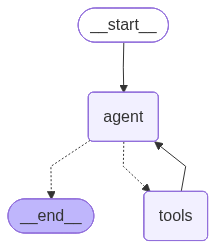

In [10]:
agent

In [11]:
from langchain_core.messages import HumanMessage

for chunk in agent.stream({"messages": [HumanMessage(content="사내 네트워크 담당자는 누구인가요?")]}, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

사내 네트워크 담당자는 누구인가요?
================================== Ai Message ==================================
Tool Calls:
  check_faq (call_zvoZyHiBC2jGdZv1pw2jy2fc)
 Call ID: call_zvoZyHiBC2jGdZv1pw2jy2fc
  Args:
    question: 사내 네트워크 담당자는 누구인가요?
================================= Tool Message =================================
Name: check_faq

{"is_in_faq": false, "context": []}
================================== Ai Message ==================================
Tool Calls:
  get_document_name (call_yf2Ou6TujCnXZpbDhB2BsqrP)
 Call ID: call_yf2Ou6TujCnXZpbDhB2BsqrP
  Args:
    question: 사내 네트워크 담당자는 누구인가요?
================================= Tool Message =================================
Name: get_document_name

it_support_guide
================================== Ai Message ==================================
Tool Calls:
  retriever_tool (call_2ziW2xClhqqYtVvXaqrERW4Z)
 Call ID: call_2ziW2xClhqqYtVvXaqrERW4Z
  Args:
    q

In [12]:
for chunk in agent.stream({"messages": [HumanMessage(content="출산휴가는 얼마나 보장되나요?")]}, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

출산휴가는 얼마나 보장되나요?
================================== Ai Message ==================================
Tool Calls:
  check_faq (call_vwW8yI9VyTTS0McBmCsTdyBu)
 Call ID: call_vwW8yI9VyTTS0McBmCsTdyBu
  Args:
    question: 출산휴가 기간
================================= Tool Message =================================
Name: check_faq

{'is_in_faq': True, 'context': [Document(id='f888c9e4-f0d8-4684-ad80-12b3a6081faf', metadata={'chapter': '2. 출산 및 육아 휴가 관련', 'section': 'Q4: 출산 휴가는 언제부터 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 출산 예정일 전후로 자유롭게 사용할 수 있으며, 최대 20일 유급으로 제공됩니다.'), Document(id='2d154525-7dfd-4519-a991-f37cdbf520fa', metadata={'chapter': '3. 경조 휴가 및 지원', 'section': 'Q6: 경조 휴가는 어떤 경우에 사용할 수 있나요?', 'source': 'employee_benefits_and_welfare_faq', 'title': '직원 복리후생 및 복지 FAQ'}, page_content='- **A:** 본인 결혼, 자녀 출생, 부모/배우자 사망 등 경조사 사유에 따라 휴가가 부여됩니다.'